<a href="https://colab.research.google.com/github/ai-fast-track/mantisshrimp/blob/getting-start/Copy_of_01_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Mantisshrimp
![](https://github.com/ai-fast-track/mantisshrimp/blob/getting-start/images/mantisshrimp-logo.png?raw=1)

## Why Mantishrimp?

- It is an Agnostic Object-Detection Library

- Connects to different libraries/framework such as fastai, Pytorch Lightning, and Pytorch

- Features a Unified Data API such: common Parsers (COCO, VOC, etc.)

- Integrates community maintaned parsers for custom datasets shared on parsers hub

- Provides flexible model implementations using different backbones

- Helps both researchers and DL engineers in reproducing, replicating published models

- Facilitates applying both existing and new models to standard datasets as well as to Scustom datasets

## 1- Introduction

This tutorial walk you throug the different steps of training the PETS dataset. the Mantisshrimp Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) library.

## 2- Using Google Colab
First, enable the GPU runtime:  
`Runtime` -> `Change runtime type` -> `Hardware accelerator dropdown` -> `GPU`  

## 3- Packages Installations

In [ ]:
# Install Mantisshrimp package
!pip install git+git://github.com/lgvaz/mantisshrimp.git

In [ ]:
# Install cocoapi and albumentations packages
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install albumentations --upgrade

In [ ]:
# Install fastai and/or Pytorch-Lightning
!pip install fastai2
!pip install pytorch-lightning

## 4- Imports

In [4]:
from mantisshrimp.imports import *
from mantisshrimp import *
import albumentations as A

## 5- Datasets : PETS example

Mantisshrimp provides very handy methods such as loading a dataset, parsing annotations, and more. In the example below, loading the PETS dataset is one line code. So is the pasrser.

In [5]:
path = datasets.pets.load()
path

Path('/root/.mantisshrimp/data/pets')

### 5.1- Parser
The `Parser` is one of the most important concepts of mantisshrimp, it's what allow us to work with **any** annotation format.

The basic idea of a parser is to convert any custom format to something the library can understand. We provide a wide variety of parsers via the `datasets` modules (each dataset will come with it's own parser), but you might still need to create a custom parser for your custom dataset. Fear not! Creating parsers is very easy, after you're finished with this tutorial, check this [documentation section](https://lgvaz.github.io/mantisshrimp/tutorials/mantisshrimp_data/intro_parser.html) to understand how to do so.

Mantisshrimp already provide a `parser` for the Pets Dataset

In [6]:
parser = datasets.pets.parser(path)

In [7]:
dir(datasets.pets)

['CLASSES',
 'PetsMaskFile',
 'PetsMaskParser',
 'PetsXmlParser',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'data',
 'load',
 'parser',
 'parsers',
 'plot_size_histogram',
 'visualization']

In [91]:
# For convenience
CLASSES = datasets.pets.CLASSES

### 5.2- Split the dataset
Next step is to define the `train/valid` splits for the data, let's use random splits for this one:


In [8]:
data_splitter = RandomSplitter([.8, .2])

### 5.3- Parsing data
Calling the `parse()` by passing the data splitter returns 2 records lists: one for the training and another for the validation datasets. 


In [9]:
train_records, valid_records = parser.parse(data_splitter)

<div class="alert alert-warning">

**Important**

A record is a dictionary that contains all parsed fields defined by the parser used. No matter what format the annotations used, a record has a common structure that can be connected to different DL frameworks (fastai, Pytorch-Lightning, etc.)

</div>

### 5.3- Visualization

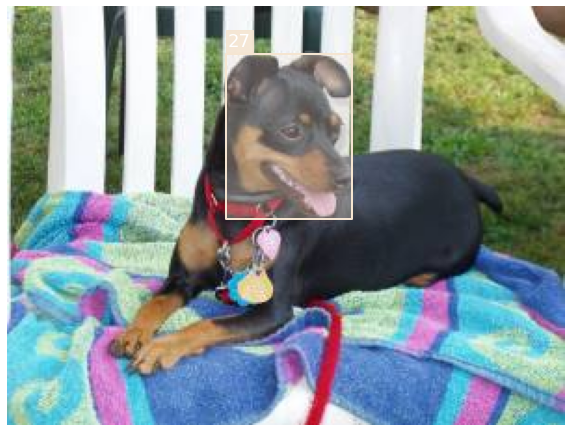

In [10]:
# show one single record (image + box + label)
show_record(train_records[0])

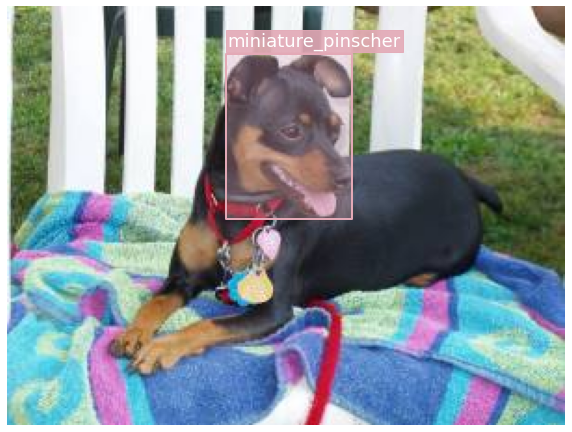

In [93]:
# show one single record (image + box + label)
show_record(train_records[0], classes=CLASSES)

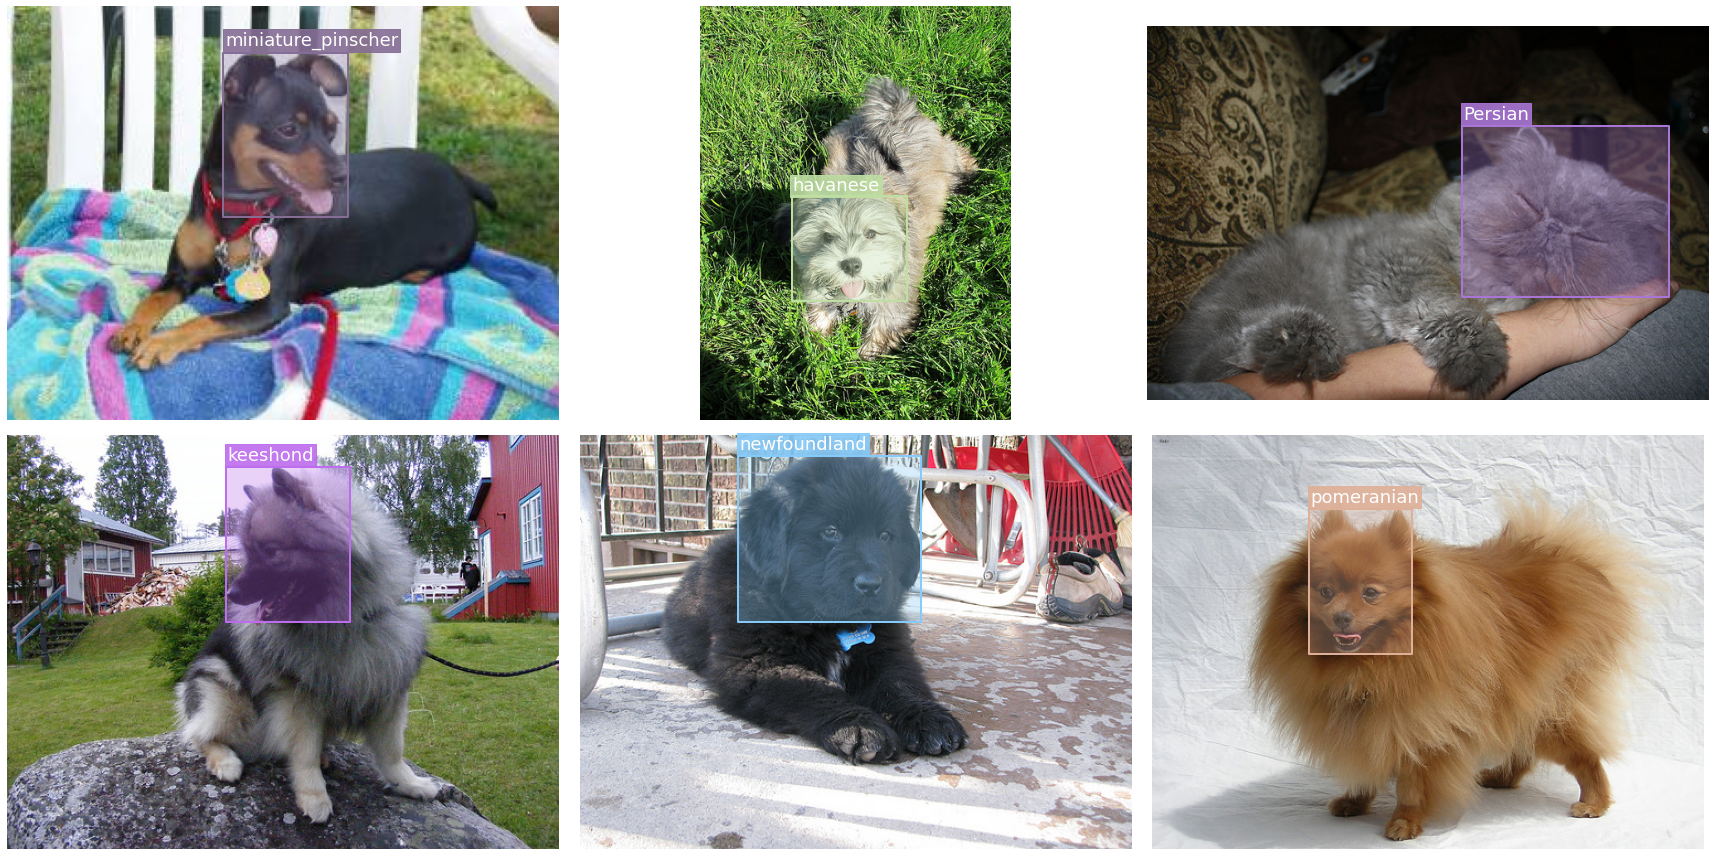

In [94]:
records = train_records[:6]
show_records(records, ncols=3, classes=CLASSES)

### 5.4- Plot Pets dataset height and width histogram

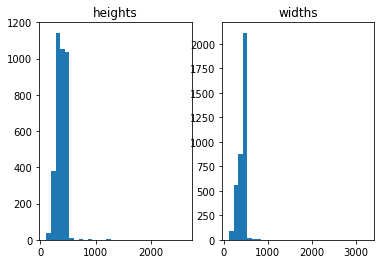

In [13]:
all_records = train_records + valid_records
_ = datasets.pets.plot_size_histogram(all_records)

## 6- Transforms

Transforms is an essential stage of any training pipeline, you can find a multitude of different transforms libraries online: [albumentations](https://github.com/albumentations-team/albumentations), [solt](https://github.com/MIPT-Oulu/solt), [torchvision](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image), only to cite a few.

With mantisshrimp you can use any transforms library, you just need to inherit and override all abstract methods of the `Transform` class.

To ease the user experience, we support for the widely used [albumentations](https://github.com/albumentations-team/albumentations) library, out-of-the-box. We plan to add more, in the future.

### 6.1- Train dataset Transforms

In [18]:
# ImageNet stats
imagenet_mean, imagenet_std = IMAGENET_STATS

train_tfms = AlbuTransform(
    [
        A.LongestMaxSize(384),
        A.RandomSizedBBoxSafeCrop(320, 320, p=0.3),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(rotate_limit=20),
        A.RGBShift(always_apply=True),
        A.RandomBrightnessContrast(),
        A.Blur(blur_limit=(1, 3)),
        A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

### 6.2- Validation Dataset Transforms

In [19]:
valid_tfms = AlbuTransform(
    [
        A.LongestMaxSize(384),
        A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

<div class="alert alert-warning">

**Important:**

The order of the transforms in the list matter!

</div>

## 7- Dataset

Not to be confused with our previous `datasets` module, `Dataset` is a class that combines the records and transforms.

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally the transforms.


In [20]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

<div class="alert alert-warning">
What a `Dataset` class  does:  
* Prepares the record: For example, in the record we just have a filename that points to the image, it's at this stage that we open the image. 
* Apply the pipeline of transforms to record processed in the previous step
</div>

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

<div class="alert alert-warning">

**Important:**

Because we normalized our images with `imagenet_stats`, when displaying transformed images,  we need to denormalize them.

The `show_sample` function receives an optional argument called `denormalize_fn` that we can be passed: In our case, we pass `denormalize_imagenet`.

</div>

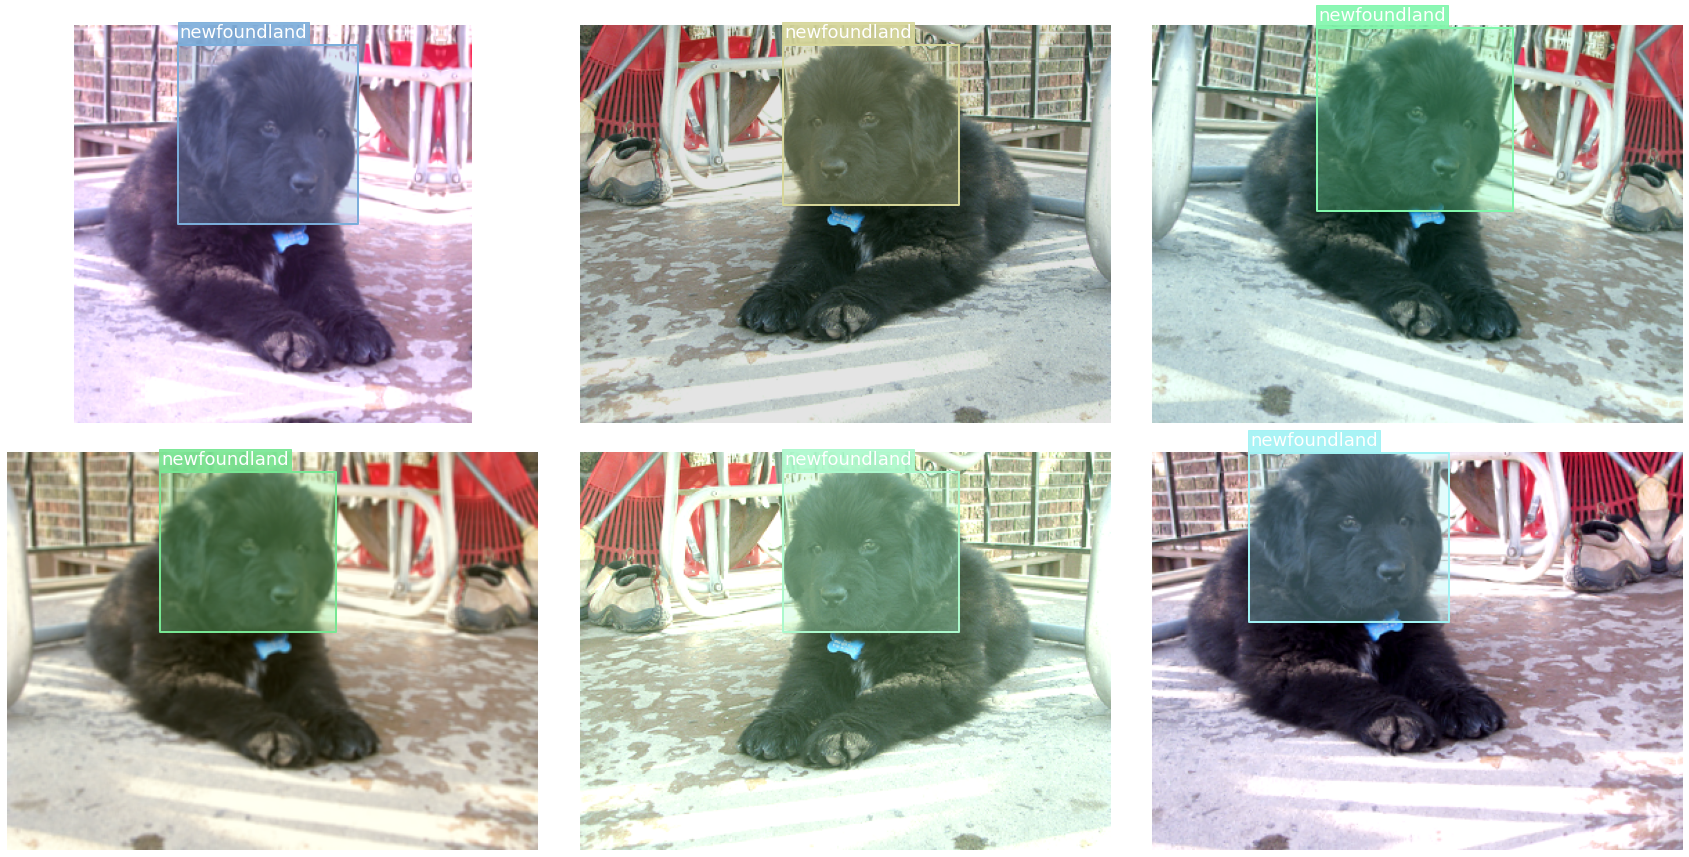

In [95]:
# Display the same image with different transforms
samples = [train_ds[4] for _ in range(6)]
show_samples(samples, ncols=3, classes=CLASSES, denormalize_fn=denormalize_imagenet)

In this tutorial, we need to only predict bounding boxes, therefore we will use `FasterRCNN`. The only required argument we need to pass to the model is the number of classes of our dataset (which is simply the length of `datasets.pets.CATEGORIES`) + 1 for the background.

## 8- Model

In [92]:
model = MantisFasterRCNN(num_classes= len(CLASSES))

In [73]:
# Use `cuda` (GPU)
model.to('cuda')
model.device

device(type='cuda', index=0)

## 9- DataLoader

Each model has its own dataloader (a pytorch `DataLoader`) that ccould be customized: the dataloaders for the RCNN models have a custom collate function.

In [74]:
train_dl = model.dataloader(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model.dataloader(valid_ds, batch_size=16, num_workers=4, shuffle=False)

## 10- Training

Mantisshrimp is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### 10.1- Training using fastai
For getting access to the helper functions to train with fastai, just `import` as follows:

In [81]:
# import fastai engine provided by the mantisshrimp modules
from mantisshrimp.engines.fastai import *

#### 10.1.1- Creating a Learner object
Creating a fastai compatible `Learner` using the fastai familiar interface 

In [82]:
learn = rcnn_learner(dls=[train_dl, valid_dl], model=model)

/usr/local/lib/python3.6/dist-packages/fastai2/callback/core.py:29: UserWarning: You are setting an attribute (loss) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")


#### 10.1.2- Training the RCNN model using fastai `fine_tune()` method

In [83]:
learn.fine_tune(10, lr=1e-4)

### 10.2- Training using Pytorch-Lightning

In [85]:
# import lightning engine provided by the mantisshrimp modules
from mantisshrimp.engines.lightning import *

#### 10.2.1- Creating a Pytorch-Lightning (PL) model class
It inherits from `RCNNLightningAdapter` and implements the method PL `configure_optimizers`.  

In [86]:
class LightModel(RCNNLightningAdapter):
    def configur1e_optimizers(self):
        opt = SGD(self.parameters(), 2e-4, momentum=0.9)
        return opt

<div class="alert alert-info">
    
**Note:**
    
If you are used with lightning, you may be wondering what happened with `training_step`, `validation_step` and methods that we ussually have to override while using PL. Under the hood `RCNNLightningAdapter` implements those methods with the additional bennefit of supporting `Metric`s.  

If you need more custom functionality, feel free to re-implement those methods.  
    
</div>

In [87]:
# Creating a PL model object
light_model = LightModel(model, metrics=metrics)

#### 10.2.2- Training the RCNN model using PL `Trainer.fit()` method

In [88]:
trainer = Trainer(max_epochs=3, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


MisconfigurationException: ignored

## 11- Inference

### 11.1- Load a model

Training the model with `fastai` using `fine_tune` twice and I got led tp the following results:  
* train_loss: 0.06772  
* valid_loss: 0.074435  

#### 11.2- Using our Trained Weights
If you don't want to train the model, you can use our rained weights that we publicly made vailable: You can download them with `torch.hub`:

In [44]:
weights_url = "https://mantisshrimp-models.s3.us-east-2.amazonaws.com/weights-384px-adam2%2B%2B.pth.zip"
state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device("cuda"))

<div class="alert alert-info">

**Note:**  

Typically inference is done on the cpu, this is why we specify the paramater `map_location` to `cpu` when loading the state dict.

</div>

Let's recreate the model and load the downloaded weights:

In [96]:
model = MantisFasterRCNN(num_classes= len(CLASSES))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
model.to('cuda')
model.device

device(type='cuda', index=0)

The first step for prediction is to have some images, let's grab some random ones from the validation dataset:

### 11.3- Predict all at once

In [61]:
samples = random.choices(valid_ds, k=6)
images = [sample["img"] for sample in samples]

Every model has a `predict` method, the first argument should always be the a list of images, the other parameters might vary a bit, and are specific to the model you are using. 

For `FasterRCNN` we have `detection_threshold`, which specifies how confident the model should be to output a bounding box.

In [62]:
preds = model.predict(images, detection_threshold=.8)


Diplay a set of images with their corresponding predictions (boxes + labesl)

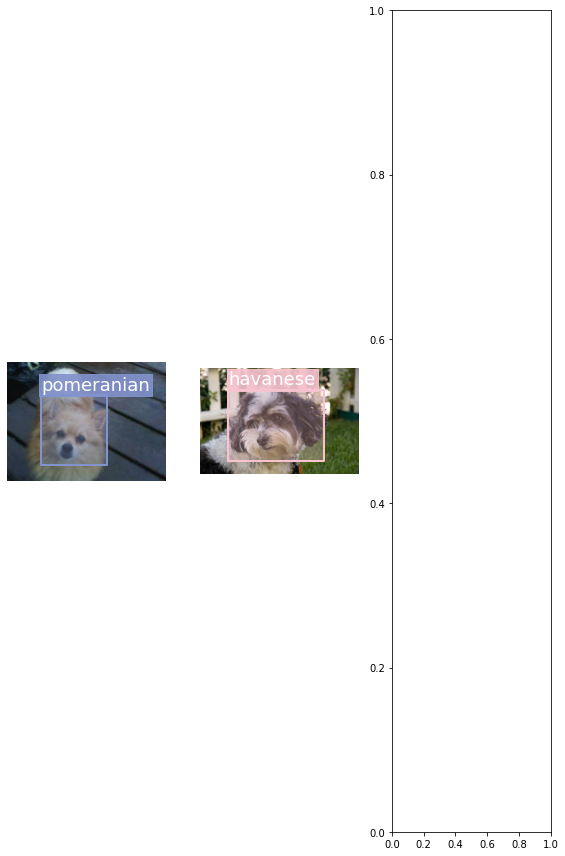

In [98]:
show_preds(images, preds, ncols=3, classes=CLASSES, denormalize_fn=denormalize_imagenet)

### 11.3- Predict a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 

Had we have a test dataset, we woul have make our predicition using the batch technique mentionned here above. As illustrative example, we will predict all images belonging to the validation dataset using the following approach: 

In [65]:
dl = DataLoader(valid_ds, batch_size=8, collate_fn=lambda o: o)

<div class="alert alert-warning">

**Important:**

The default `DataLoader` tries to collate (combine the items) of the batch in a very specific way, specifying `collate_fn=lambda o: o` is saying "whatever you receive as a batch, return it without modifications" because the validation dataset is already collated (processed).

</div>

Using a simple iterator over the dataloader, we can make predictions for each batch:

In [67]:
all_preds = []
for batch in dl:
    images = [sample["img"] for sample in batch]

    preds = model.predict(images, detection_threshold=.8)
    all_preds.append(preds)

In [68]:
all_preds[0]

[{'above_threshold': tensor([ True, False], device='cuda:0'),
  'bboxes': [BBox(pnts=[40.996063232421875, 62.761878967285156, 215.01315307617188, 200.5941162109375])],
  'labels': array([16]),
  'scores': array([0.9821828], dtype=float32)},
 {'above_threshold': tensor([ True, False], device='cuda:0'),
  'bboxes': [BBox(pnts=[187.83035278320312, 0.0, 326.0413513183594, 180.013916015625])],
  'labels': array([9]),
  'scores': array([0.8850003], dtype=float32)},
 {'above_threshold': tensor([ True, False, False, False, False, False], device='cuda:0'),
  'bboxes': [BBox(pnts=[186.77044677734375, 70.39146423339844, 267.2652893066406, 152.74099731445312])],
  'labels': array([32]),
  'scores': array([0.9150888], dtype=float32)},
 {'above_threshold': tensor([True], device='cuda:0'),
  'bboxes': [BBox(pnts=[74.81196594238281, 45.55850601196289, 194.00669860839844, 146.48834228515625])],
  'labels': array([30]),
  'scores': array([0.99864477], dtype=float32)},
 {'above_threshold': tensor([ True,

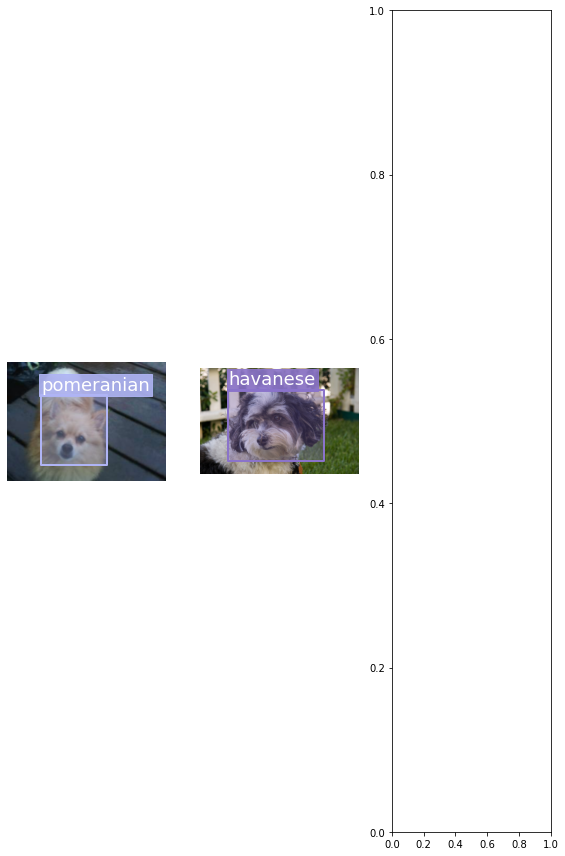

In [99]:
show_preds(images[:6], preds[:6], ncols=3, classes=CLASSES, denormalize_fn=denormalize_imagenet)

# Happy Learning!

If you need any assistance, feel free to reach out at us [here](https://github.com/lgvaz/mantisshrimp/tree/master/mantisshrimp)